TensorFlow Hub is an online repository of already trained TensorFlow models that you can use. These models can either be used as is, or they can be used for Transfer Learning.

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.

In this Colab we will do both.

Here, you can see all the models available in TensorFlow Module Hub.

Concepts that will be covered in this Colab
Use a TensorFlow Hub model for prediction.
Use a TensorFlow Hub model for Dogs vs. Cats dataset.
Do simple transfer learning with TensorFlow Hub.
Before starting this Colab, you should reset the Colab environment by selecting Runtime -> Reset all runtimes... from menu above.

In [1]:
#Downloading and installing tensorflow_hub
#!pip install --upgrade tensorflow_hub
#!pip install tensorflow_datasets

In [2]:
#importing modules
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import layers
import os

# Part 1: Use a TensorFlow Hub MobileNet for prediction
In this part of the Colab, we'll take a trained model, load it into to Keras, and try it out.

The model that we'll use is MobileNet v2 (but any model from tf2 compatible image classifier URL from tfhub.dev would work).

# Download the classifier
Download the MobileNet model and create a Keras model from it. MobileNet is expecting images of 224  ×  224 pixels, in 3 color channels (RGB).

In [3]:
#This time we will use url for importing MobileNetV2
classification_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
image_shape = 224  #size/shape the model takes the picture in..

model = tf.keras.Sequential([
    hub.KerasLayer(classification_url, input_shape=(image_shape, image_shape, 3))
])

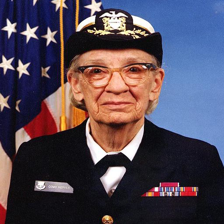

In [4]:
import PIL.Image
image = "grace_hopper.jpg"
image = PIL.Image.open(image).resize((image_shape, image_shape))
image

In [5]:
image = np.array(image)/255
print(image.shape)

(224, 224, 3)


In [6]:
result = model.predict(image[np.newaxis])   #Here we need to predict model through axis.
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax. But how can we know what class this actually is and in particular if that class ID in the ImageNet dataset denotes a military uniform or something else?

In [7]:
predicted = np.argmax(result[0], axis=-1)
predicted

653

# Now Decode the predictions
To see what our predicted_class is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

Text(0.5, 1.0, 'Prediction: Military Uniform')

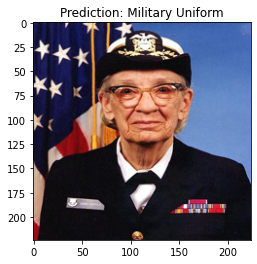

In [8]:
label_path = tf.keras.utils.get_file('ImageLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(label_path).read().splitlines())
plt.imshow(image)
predicted_classname = imagenet_labels[predicted]
plt.title("Prediction: "+predicted_classname.title())

Our model is Working Perfectly

# Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset
Now we'll use the full MobileNet model and see how it can perform on the Dogs vs. Cats dataset.

In [9]:
(database, metadata), info= tfds.load('cats_vs_dogs', as_supervised=True, with_info=True, split=['train[:80%]', 'train[80%:]'])

In [10]:
num_examples = info.splits['train'].num_examples
classes = info.features['label'].num_classes
print(num_examples)
print(classes)

23262
2


In [11]:
for label, image in enumerate(database.take(3)):
    print("the label: ",label+1,"and image is: ",image[0].shape)

the label:  1 and image is:  (262, 350, 3)
the label:  2 and image is:  (409, 336, 3)
the label:  3 and image is:  (493, 500, 3)


So we need to reformat all images to the resolution expected by MobileNet (224, 224).

The .repeat() and steps_per_epoch here is not required, but saves ~15s per epoch, since the shuffle-buffer only has to cold-start once.

In [12]:
def format_image(image, label):
    image = tf.image.resize(image, (image_shape, image_shape))/255.0
    return image, label

BATCH_SIZE = 32

train_batches      = database.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = metadata.map(format_image).batch(BATCH_SIZE).prefetch(1)

# Run the classifier on a batch of images
Remember our model object is still the full MobileNet model trained on ImageNet, so it has 1000 possible output classes. ImageNet has a lot of dogs and cats in it, so let's see if it can predict the images in our Dogs vs. Cats dataset.

In [13]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Persian cat', 'Egyptian cat', 'tabby', 'schipperke', 'tabby',
       'Egyptian cat', 'tabby', 'Persian cat', 'vizsla', 'Angora',
       'Persian cat', 'Egyptian cat', 'Siamese cat', 'Siberian husky',
       'German short-haired pointer', 'Chihuahua', 'Egyptian cat',
       'miniature pinscher', 'tabby', 'kelpie', 'tabby',
       'miniature poodle', 'Labrador retriever', 'lynx',
       'Italian greyhound', 'Egyptian cat', 'Egyptian cat',
       'English foxhound', 'Gordon setter', 'Labrador retriever',
       'German shepherd', 'Chihuahua'], dtype='<U30')

The labels seem to match names of Dogs and Cats. Let's now plot the images from our Dogs vs Cats dataset and put the ImageNet labels next to them.

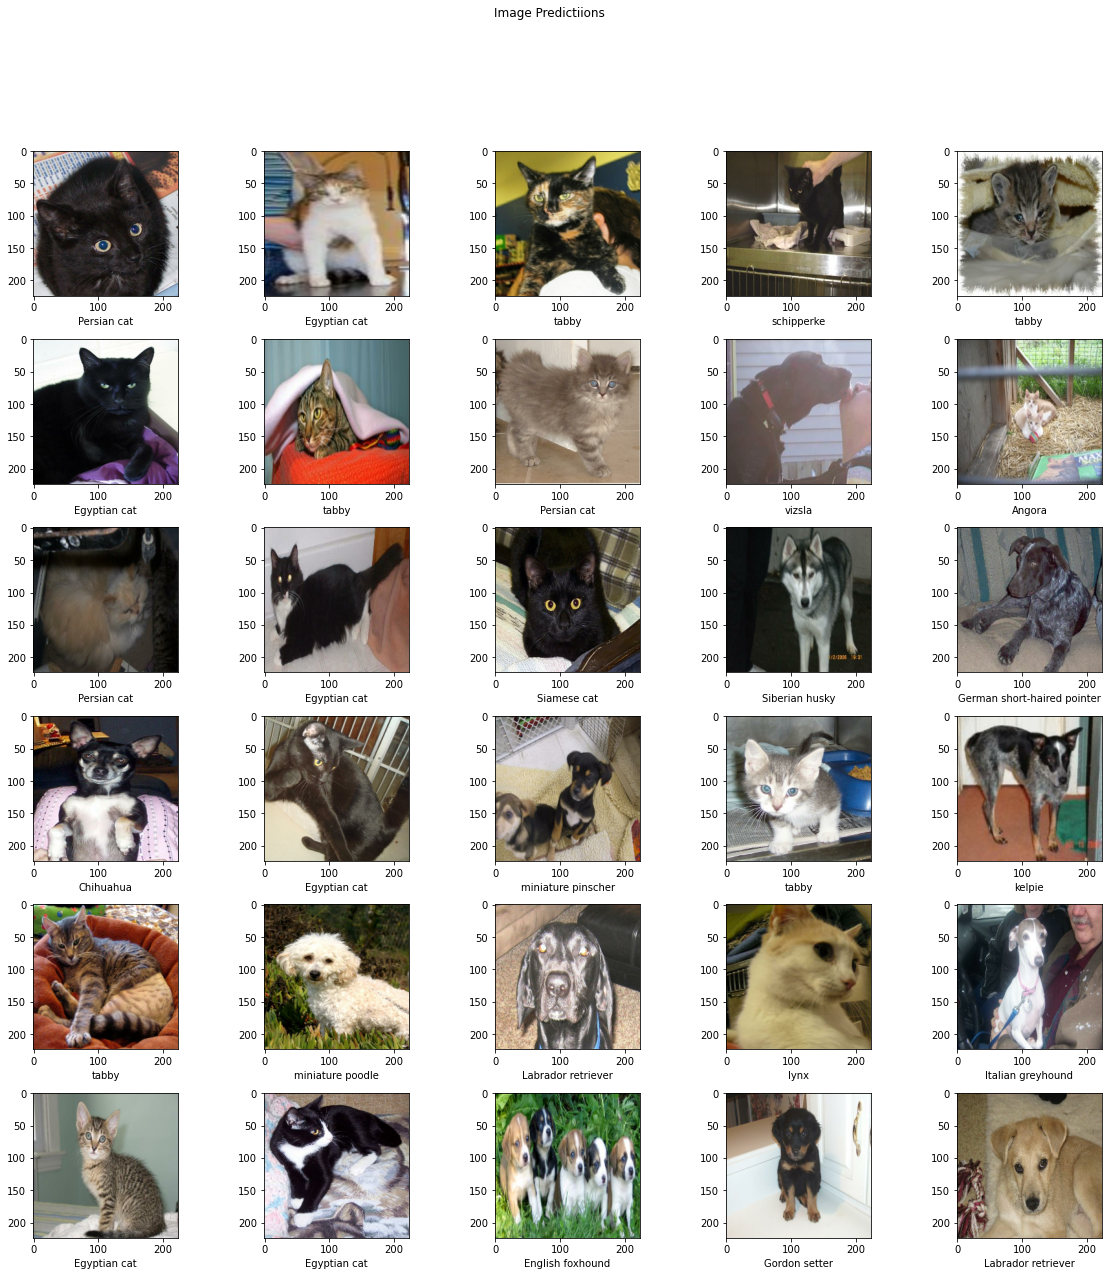

In [14]:
def plot(batch, label):
    plt.figure(figsize=(20,20))
    for i in range(30):
        plt.subplot(6, 5, i+1)
        plt.subplots_adjust(hspace=0.3)
        plt.imshow(batch[i])
        plt.xlabel(label[i])
    plt.suptitle("Image Predictiions")
plot(image_batch, predicted_class_names)

# Part 3: Do simple transfer learning with TensorFlow Hub
Let's now use TensorFlow Hub to do Transfer Learning.

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning. We will continue using MobileNet v2 because in later parts of this course, we will take this model and deploy it on a mobile device using TensorFlow Lite. Any image feature vector URL from tfhub.dev would work here.

We'll also continue to use the Dogs vs Cats dataset, so we will be able to compare the performance of this model against the ones we created from scratch earlier.

Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a feature_extractor. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.

In [15]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(image_shape, image_shape,3))

Let's run a batch of images through this, and see the final shape. 32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.

In [16]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [17]:
feature_extractor.trainable = False

# Attach a classification head
Now wrap the hub layer in a tf.keras.Sequential model, and add a new classification layer.

In [18]:
model = tf.keras.Sequential([feature_extractor, 
                             tf.keras.layers.Dense(units =2)])

In [19]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
None


# Train the model

In [20]:
#before that compiling the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
Epochs = 6
history = model.fit(train_batches, epochs=Epochs, validation_data=validation_batches)

Epoch 1/6
  4/582 [..............................] - ETA: 8:36 - loss: 0.7298 - accuracy: 0.5703

You can see we get ~97% validation accuracy, which is absolutely awesome. This is a huge improvement over the model we created in the previous lesson, where we were able to get ~83% accuracy. The reason for this difference is that MobileNet was carefully designed over a long time by experts, then trained on a massive dataset (ImageNet).

Although not equivalent to TensorFlow Hub, you can check out how to create MobileNet in Keras here.

Let's plot the training and validation accuracy/loss graphs.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()